# <img src="https://raw.githubusercontent.com/alsinmr/SLEEPY_tutorial/033b817f027ebdcd6493a1f42ab9fdec290dbee8/JupyterBook/favicon.png"  width=40> <font  color = "#0093AF">A Quick Start</font>

We will go through the various objects in this chapter in detail, but in this section we will just do a quick summary. Note that we will usually use consistent variable names for each class (i.e. type of object). These names are given in () after each class name. We should note that we abbreviate the SLEEPY module as `sl`

- ExpSys (`ex`): Describes basic details of the experiment and spin-system. This includes magnetic field, nuclei in the system, spinning frequency, temperature, powder average, spin-field and spin-spin interactions, etc.
- Liouvillian (`L`): Contains the Liouvillian, which has coherent terms originating from interactions in ExpSys, but also can contain relaxation terms, and potentially includes exchange processes that modulate interactions, defined by including two or more ExpSys in exchange.
- Hamiltonian (`H`): Contains the Hamiltonian, although the user can bypass the Hamiltonian and generate the Liouvillian directly (Hamiltonians are contained within the Liouvillian).
- Sequence (`seq`): Generated from a Liouvillian, and allows the user to define time-dependent, multi-channel pulse sequences. Sequences can be used directly with the density matrix, or can be used to generate propagators.
- Propagator (`U`): Propagates the density matrix forward in time. Propagators can be generated from a sequence, in which case they can include RF-pulses in the sequence, or from the Liouvillian directly, in which case no RF irradiation is included. Identity propagators and $\delta$-pulses are generated by the Liouvillian. Propagators may be multiplied together or the density matrix may be multiplied with a propagator. Propagators may also be raised to integer powers (in solid-state NMR, this requires that the propagator is exactly one rotor period).
- Rho (`rho`): Rho is the density matrix, which defines the state of the spin-system. In SLEEPY, rho also contains the detection operator, so that simply calling rho (`rho()`) will perform a detection operation for the current state of the density matrix. Rho records all detection operations and stores the results in `rho.I`, which is a 2D matrix (the first dimension runs over possible multiple detection operators, the second dimension runs over all detection calls). A special function, `rho.DetProp` takes a sequence or propagator and executes multiple detection and propagation steps. DetProp usually operates in the propagator eigenbasis, making this calculation much faster than simply looping over propagation and detection operations (it may also use multiple eigenbases if a sequence is provided for which multiple detections should occur during the rotor period). DetProp will also try to reduce the matrix sizes before calculating propagators from sequences. The `rho.plot(...)` function will plot either time-domain or Fourier transformed spectra (`FT=True`).

Note that SLEEPY is intended to be *interactive*, so each of these objects will provide a description of itself if its variable name is typed at the command line, or included in a "print" call. Furthermore, each object has a "plot" function (or "plot_inter" for ExpSys), that gives a graphical representation of the object or a plot of data in the object. Objects may be investigated by the user and many of their attributes provide useful information. `dir(obj)` will list attributes of the object, which the user may then access the attributes to see what they contain or do.

## Setup

In [0]:
# SETUP SLEEPY
!pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

Loading Defaults from file


## Example: $^{13}$C $R_{1\rho}$

Below, we will construct a simulation for $R_{1\rho}$ relaxation. The first step is to define the spins in the system, their interactions, and the experimental conditions. Since we want a dynamic system, we define two systems (`ex0`,`ex1`), which differ by the orientation of the dipole coupling. The `ExpSys` class provides a copy function, which should be used to ensure the experimental settings are consistent between the two systems (experimental settings are always read out of the first `ExpSys` object).

In [3]:
# 600 MHz, H-C system, MAS at 60 kHz, 49 powder angles (JPC59), 50 steps per rotor period
ex0=sl.ExpSys(v0H=600,Nucs=['13C','1H'],vr=60000,pwdavg=2,n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000) #One-bond H-C dipole coupling
ex1=ex0.copy() #Copy the above setup
#Reorient the dipole coupling by 30 degrees
_=ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler_d=[0,30,0]) 

Next we build a Liouvillian (`L=sl.Liouvillian(...)`) out of the two spin-systems, and add an exchange matrix to it.

In [4]:
# Liouvillian, with ex0 and ex1 included
L=sl.Liouvillian(ex0,ex1)
# Add symmetric exchange matrix to Liouvillian, with 5 microsecond tc
tc=5e-6
L.kex=1/(2*tc)*np.array([[-1,1],[1,-1]])

If we want to add RF-fields, we should generate a sequence (`seq=L.Sequence()`). For $R_{1\rho}$, this is just a constant field. We specify the time axis, although for a constant field we can also omit this, in which case we get a sequence with the default length of one rotor period. We also plot the sequence below.

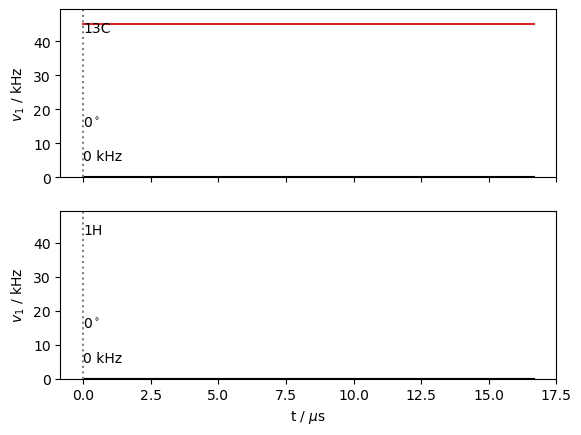

In [5]:
#Generate a pulse-sequence from L
seq=L.Sequence()
# Add a 45 kHz pulse on the 13C channel (x), for one rotor period (this is the default, so could be omitted)
seq.add_channel('13C',t=[0,L.taur],v1=45000,phase=0)
# Plot the pulse-sequence
_=seq.plot()

We can plot a graphical representation of the Liouville matrix below. If the sequence (`seq`) is provided when plotting `L`, the maximum field on each channel of the sequence is included in the representation.

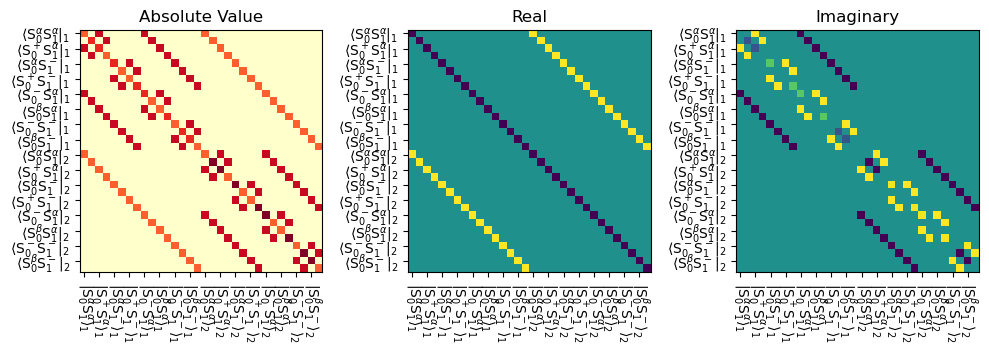

In [6]:
# Graphical representation of L, where the applied field is included by defining seq
# Plotted as the absolute value, but also separated into real and imaginary components.
fig,ax=plt.subplots(1,3,figsize=[10,5])
L.plot(seq=seq,mode='abs',ax=ax[0],colorbar=False)
ax[0].set_title('Absolute Value')
L.plot(seq=seq,mode='re',ax=ax[1],colorbar=False)
ax[1].set_title('Real')
L.plot(seq=seq,mode='im',ax=ax[2],colorbar=False)
ax[2].set_title('Imaginary')
fig.tight_layout()

We create the density matrix and specify the detection operator (`rho=sl.Rho(...)
`). Here we initialize it along the *z*-axis, so that we can show as an example how to make a $\delta$-pulse and apply it to the matrix (normally, we would skip the $\delta$-pulse and just initialize along the *x*-axis).

In [7]:
# Create a density matrix, with initial state and detection matrix
# We'll start with '13Cz', so we can demonstrate how to use a delta-pulse to bring the magnetization to x
rho=sl.Rho(rho0='13Cz',detect='13Cx')

In [8]:
#13C pi/2 delta pulse along y
Upi2y=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)
# Apply the pi/2 pulse to rho
Upi2y*rho

Density Matrix/Detection Operator
rho0: 13Cz
detect[0]: 13Cx
Current time is 0.000 microseconds
0 time points have been recorded


Above, we see the description of the density matrix, which is updated as it is propagated (see below).

In [9]:
# Apply the sequence to rho 1000 times, detecting at each step
# Here we use the DetProp function, which will perform this operation in the eigenbasis
rho.DetProp(seq,n=1000)

State-space reduction: 32->16


Density Matrix/Detection Operator
rho0: 13Cz
detect[0]: 13Cx
Current time is 16666.667 microseconds
1000 time points have been recorded


Finally, we plot the resulting $R_{1\rho}$ decay curve (plot also has a Fourier transform option, `FT=True`).

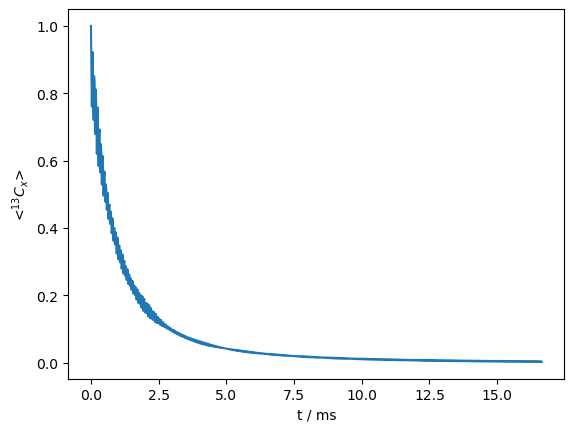

In [10]:
# Plot the resulting time-dependent magnetization
_=rho.plot()